In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [2]:
fishes = 4

In [30]:
from sklearn.mixture import GaussianMixture
import sklearn.cluster as cl
import sklearn.metrics as mt
import random

class EMAlgorithmFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    """
    Representation of a Gaussian mixture model probability distribution. 
    GMMs are probabilistic models that assume all the data points are generated 
    from a mixture of several Gaussian distributions with unknown parameters.

    The EM algorithm is an iterative approach that cycles between two modes:
    E-Step. Estimate the missing variables in the dataset.
    M-Step. Maximize the parameters of the model in the presence of the data.
    """
    def __init__(self):
        self.model = GaussianMixture(n_components=3,
                                     covariance_type='full',
                                     tol=0.01,
                                     max_iter=1000)
        
    
    def choose_action(self, view: np.ndarray):
        
        prediction = self.model.predict_proba([view])
        #print(self.model.means_)
        #print(self.model.covariances_)
        print(prediction)
        
        speed = prediction[0][0]
        turn = prediction[0][1]
        
        # turn correction for walls avoidance
        turn = self.avoid_walls(view, turn)
        
        return speed, turn
    
    def avoid_walls(self, view, turn):
        """
        Forces to turn a fish in a random direction
        if in a view's raycast of the walls
        a wall in the front of a fish is detected to near

        Parameters
        ---------
        view : array_like
            The observations of the virtual fish
        turn : float
            Turn predicted by a model that is to modify

        Returns
        ---------
        turn : float
            Original or modified turn depending on the wall distance
        """
        param = random.randint(-5, 5)
        
        if param == 0:
            param = random.randint(5, 11)
        
        if view[6] > 0.9:
            return param * np.pi
        else:
            return turn
        
 
    def fit(self, dset):
        """
        Learns parameters and runs the the two steps of EM Algorithm 
        until the average log-likelihood converges.
        """
        
        X = dset[:]["views"]
        y = dset[:]["actions"]
        
        self.model.fit(X, y)
        
    
model = EMAlgorithmFishModel()

In [31]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [5]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Loading data from 5 files.


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating views from 5 files.


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]

Created IoDataset:
Reduced the first 3 dimensions from (5, 2, 8989) to (89890)
poses	(89890, 3):	consisting of x, y, calc_ori_rad.
actions	(89880, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(89880, 9):	4 fish_bins and 5 wall ray casts.



In [32]:
model.fit(dset)

In [33]:
generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=5000)

  1%|          | 31/4999 [00:00<00:32, 154.12it/s]

[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]

  1%|          | 47/4999 [00:00<00:34, 143.20it/s]


[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]

  2%|▏         | 81/4999 [00:00<00:31, 154.17it/s]


[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]

  2%|▏         | 117/4999 [00:00<00:31, 157.26it/s]


[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]

  3%|▎         | 149/4999 [00:00<00:33, 146.80it/s]

[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]

  4%|▎         | 181/4999 [00:01<00:32, 149.66it/s]

[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]

  4%|▍         | 216/4999 [00:01<00:30, 158.85it/s]


[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]

  5%|▍         | 247/4999 [00:01<00:32, 144.94it/s]


[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]

  5%|▌         | 262/4999 [00:01<00:34, 136.83it/s]

[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]

  6%|▌         | 290/4999 [00:02<00:38, 123.77it/s]


[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]

  6%|▋         | 319/4999 [00:02<00:35, 130.68it/s]


[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]

  7%|▋         | 350/4999 [00:02<00:32, 142.74it/s]


[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 1. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]

  7%|▋         | 366/4999 [00:02<00:32, 142.53it/s]

[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]


KeyboardInterrupt: 

In [24]:
f = generator.as_io_file(track)
f.save_as("output/em_algorithm.hdf5")

<HDF5 file "cd2da4c8-03aa-4103-a8f8-e985064e6995" (mode r+)>

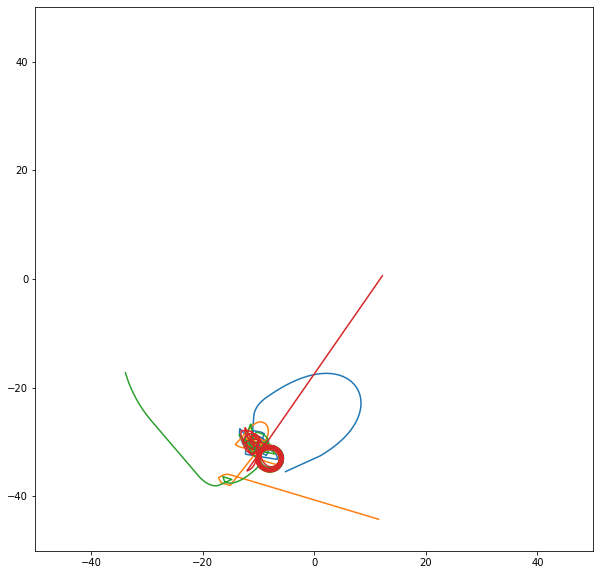

In [25]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()